GSOC'20 **Task-1** for Deep Learning Algorithms for Muon Momentum Estimation in the CMS Trigger System

by Shubham Shaswat

Email: shaswat.cpp@gmail.com

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

import tensorflow.keras as K
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd



TensorFlow 2.x selected.


In [0]:
#enable xla 
tf.config.optimizer.set_jit(True)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#path and filename of data 
path = 'drive/My Drive/Colab Data/cern'
filename = 'histos_tba.20.npz'

In [0]:
import os
os.listdir(path)

['histos_tba.20.npz']

In [0]:
#loading the data
data = np.load(os.path.join(path,filename))
lst = data.files
print(lst)

['variables', 'parameters']


In [0]:
#shape of the data
print(data['variables'].shape)

(3272341, 87)


In [0]:
#load data features for CSC

phi = data['variables'][:,0:5]
theta = data['variables'][:,12:17]
bending_angle = data['variables'][:,24:29]
ring = data['variables'][:,48:53]
hit = data['variables'][:,60:65]
mask = data['variables'][:,72:77]



In [0]:
#contenate to make single array
train_data = np.concatenate((phi,theta,bending_angle,ring,hit,mask),axis=1)

In [0]:
#load transvere momentum
pt=np.abs(1/(data['parameters'][:,0]))


In [0]:
#replace the nan with 0
mask_ = np.isnan(train_data)
train_data = np.where(mask_,0,train_data)

In [0]:
#calucate max and min of the x_train along the colums
max_arr = np.max(train_data,axis=0)
min_arr = np.min(train_data,axis=0)


In [0]:
#normalise the trainig data
train_data = (train_data-min_arr)/(max_arr - min_arr)

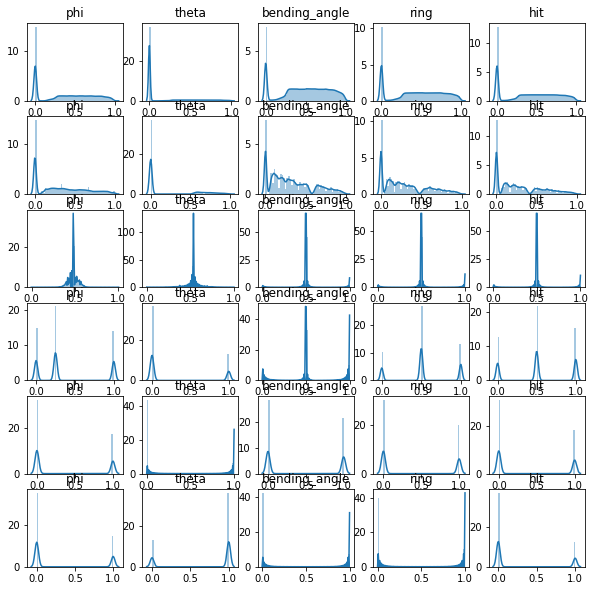

In [0]:
#distribution plots for each features after normalisation
import seaborn as sns
fig = plt.figure(figsize=(10,10))
labels = ['phi','theta','bending_angle','ring','hit','mask']
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.title(labels[i%5])
  sns.distplot(train_data[:,i])

In [0]:
#load labels into categories

pt[np.where(pt < 10)] = 0
pt[np.where((pt >= 10 )& (pt < 30))] = 1
pt[np.where((pt < 100 )& (pt >= 30))] = 2
pt[np.where(pt >= 100 )] =3
 

In [0]:
#defina a function to free mem

del data
del phi
del theta
del bending_angle
del ring
del hit
del max_arr
del min_arr
del mask
del mask_


In [0]:
#calculate the sum of labels
h=[]
for i in range(4):
  h.append(len(pt[pt==i]))


([<matplotlib.axis.XTick at 0x7f20fa726240>,
 <a list of 4 Text xticklabel objects>)

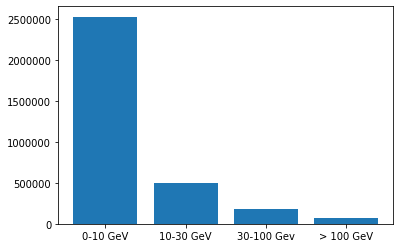

In [0]:
#plot bar for tansverse momentum labels

plt.bar(np.arange(4),h)
plt.xticks(np.arange(4), ('0-10 GeV', '10-30 GeV', '30-100 Gev', '> 100 GeV'))



In [0]:
#build a dense model
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, Dropout,MaxPooling2D

def FNN():

  inp = Input(shape=(30,))
  x = Dense(1000,activation='relu')(inp)
  x = Dense(1000,activation='relu')(x)
  x = Dropout(0.5)(x)
  out = Dense(4)(x)

  return Model(inputs=inp,outputs=out)



In [0]:
#call the model
model = FNN()

In [0]:
#compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy',metrics=['accuracy'] )

In [0]:
#train the model
history=model.fit(train_data,pt,batch_size=128,epochs=5,validation_split=0.1)

Train on 2945106 samples, validate on 327235 samples
Epoch 1/5
2945106/2945106 [==============================] - 133s 45us/sample - loss: 3.6731 - accuracy: 0.7721 - val_loss: 3.6923 - val_accuracy: 0.7709
Epoch 2/5
2945106/2945106 [==============================] - 130s 44us/sample - loss: 3.6728 - accuracy: 0.7721 - val_loss: 3.6923 - val_accuracy: 0.7709
Epoch 3/5
2945106/2945106 [==============================] - 128s 44us/sample - loss: 3.6728 - accuracy: 0.7721 - val_loss: 3.6923 - val_accuracy: 0.7709
Epoch 4/5
2945106/2945106 [==============================] - 129s 44us/sample - loss: 3.6728 - accuracy: 0.7721 - val_loss: 3.6923 - val_accuracy: 0.7709
Epoch 5/5
2945106/2945106 [==============================] - 131s 45us/sample - loss: 3.6728 - accuracy: 0.7721 - val_loss: 3.6923 - val_accuracy: 0.7709


In [0]:
#defina a convolution nueral network model


class CNN(Model):

  def __init__(self):
    super(CNN,self).__init__()

    self.cnn1 = Conv2D(10,(2,2),activation='relu')
    self.maxpool = MaxPooling2D((2,2))
    self.flatten = Flatten()
    self.dense1 = Dense(100,activation = 'relu')
    self.out = Dense(4)

  def call(self,x):

    x = self.cnn1(x)
    x = self.maxpool(x)
    x = self.dense1(x)
    x = self.flatten(x)

    x = self.out(x)

    return x

In [0]:
#loss object and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)



In [0]:
#define loss and accuracy metrics for both train and val data

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [0]:
#defina a train step
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    
    predictions = model(x, training=True)
    loss = loss_object(y, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y, predictions)

In [0]:
model = CNN()

In [0]:
#reshape the data
train_data1=np.reshape(train_data,[train_data.shape[0],6,5,1])

In [0]:
pt.shape

(3272341,)

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_data1, pt ,test_size=0.1, random_state=42)

In [0]:
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(BATCH_SIZE)



In [0]:

def train(EPOCHS=5):

 #to store accuracy and loss of train,test
  train_acc_plt = []
  train_loss_plt = []
  
  for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    

 

    for x,y in train_dataset:
      train_step(x, y)

    
    train_loss_plt.append(train_loss.result())
    train_acc_plt.append(train_accuracy.result()*100)
    

    template = 'Epoch {}, Loss: {}, Accuracy: {}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100
                          ))
    
  return train_loss_plt, train_acc_plt

In [0]:
loss_,acc_=train(EPOCHS=5)

Epoch 1, Loss: 0.5862486958503723, Accuracy: 79.55876922607422
Epoch 2, Loss: 0.4923819601535797, Accuracy: 81.52406311035156
Epoch 3, Loss: 0.4866178035736084, Accuracy: 81.72103118896484
Epoch 4, Loss: 0.4851222336292267, Accuracy: 81.76976013183594
Epoch 5, Loss: 0.48535364866256714, Accuracy: 81.76826477050781


In [0]:
y_test.shape

(327235,)

In [0]:
#function to eval test data
def eval(x_test,y_test):
  predictions = model(x_test)
  acc = test_accuracy(y_test,predictions)
  
  return predictions,acc

In [0]:
y_pred,test_acc=eval(x_test,y_test)

In [0]:
#Test accuracy
print('Test Acc = ',test_acc.numpy() )

Test Acc =  0.80497503


In [0]:
#get confusion matrix
 confusion_matrix = tf.math.confusion_matrix(y_test ,tf.math.argmax(y_pred,axis=1))


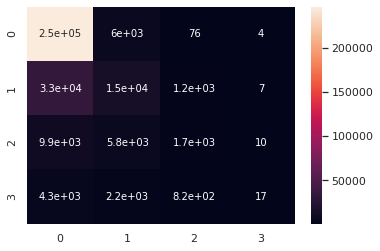

In [0]:
#draw confusion  matrix
sns.set(font_scale=1) # for label size
sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 10}) # font size

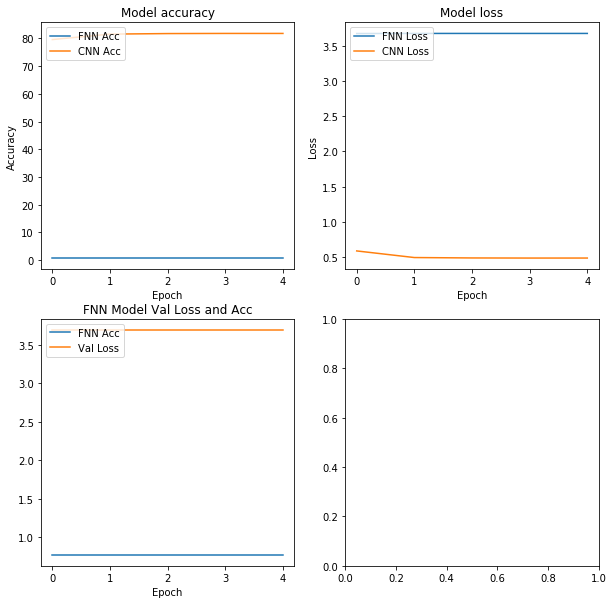

In [0]:
#plot accuracy
fig = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)

plt.plot(history.history['accuracy'])
plt.plot(acc_)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['FNN Acc', 'CNN Acc'], loc='upper left')

plt.subplot(2,2,2)

plt.plot(history.history['loss'])
plt.plot(loss_)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['FNN Loss', 'CNN Loss'], loc='upper left')

plt.subplot(2,2,3)


plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('FNN Model Val Loss and Acc')
plt.legend(['FNN Acc', 'Val Loss'], loc='upper left')
plt.xlabel('Epoch')

plt.subplot(2,2,4)








As seen from the plot using CNN over FNN,The accuarcy increased by 3% wrt 77% in FNN and 80% in CNN on test data.

We will now train the model to estimate momentum

In [0]:
#model for regression
class CNN_Reg(Model):

  def __init__(self):
    super(CNN_Reg,self).__init__()

    self.cnn1 = Conv2D(10,(2,2),activation='relu')
    self.maxpool = MaxPooling2D((2,2))
    self.flatten = Flatten()
    self.dense1 = Dense(100,activation = 'relu')
    self.out = Dense(1)

  def call(self,x):

    x = self.cnn1(x)
    x = self.maxpool(x)
    x = self.dense1(x)
    x = self.flatten(x)

    x = self.out(x)

    return x

In [0]:
#load data
data = np.load(os.path.join(path,filename))
pt_ = np.abs(data['parameters'][:,0])


In [0]:
pt_

array([0.4456128 , 0.35296607, 0.16274202, ..., 0.06879503, 0.00109554,
       0.41426006], dtype=float32)

In [0]:
train_data_reg = np.reshape(train_data,[train_data.shape[0],6,5,1])

In [0]:
#buidl a model
model=CNN_Reg()

In [0]:
#compile the model
model.compile(optimizer='adam',loss='mse',metrics=['mae', 'mse'])

In [0]:
his=model.fit(train_data_reg,pt_,epochs=5,batch_size=128,validation_split=0.1)

Train on 2945106 samples, validate on 327235 samples
Epoch 1/5
2945106/2945106 [==============================] - 91s 31us/sample - loss: 0.0083 - mae: 0.0688 - mse: 0.0083 - val_loss: 0.0056 - val_mae: 0.0542 - val_mse: 0.0056
Epoch 2/5
2945106/2945106 [==============================] - 91s 31us/sample - loss: 0.0055 - mae: 0.0535 - mse: 0.0055 - val_loss: 0.0052 - val_mae: 0.0511 - val_mse: 0.0052
Epoch 3/5
2945106/2945106 [==============================] - 90s 31us/sample - loss: 0.0053 - mae: 0.0520 - mse: 0.0053 - val_loss: 0.0049 - val_mae: 0.0501 - val_mse: 0.0049
Epoch 4/5
2945106/2945106 [==============================] - 88s 30us/sample - loss: 0.0051 - mae: 0.0511 - mse: 0.0051 - val_loss: 0.0052 - val_mae: 0.0522 - val_mse: 0.0052
Epoch 5/5
2945106/2945106 [==============================] - 88s 30us/sample - loss: 0.0048 - mae: 0.0500 - mse: 0.0048 - val_loss: 0.0046 - val_mae: 0.0485 - val_mse: 0.0046


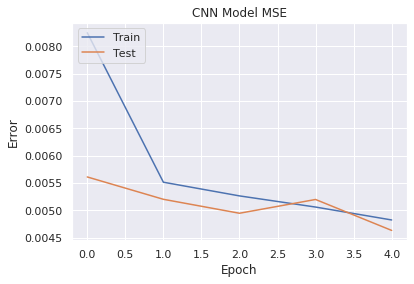

In [0]:
#plot mse 
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('CNN Model MSE')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


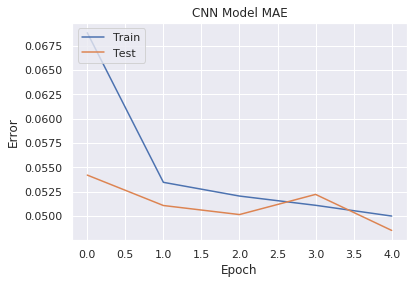

In [0]:
#plot mse 
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('CNN Model MAE')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
